In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from collections import defaultdict


from star_hard_constraints.sdf import (
    SDFHalfSpace,
    SDFIntersection,
    SDFMultiIntersection,
    SDFMultiUnion,
)
from star_hard_constraints.models import SimpleConstrainedNN, ESConstrainedNN

## Example Constraints

In [2]:
omega_dose_example = SDFMultiIntersection(
    SDFMultiUnion(
        SDFIntersection(
            SDFHalfSpace(normal=torch.tensor([0.0, 1.0]), bias=1.0),
            SDFHalfSpace(normal=torch.tensor([1.0, 0.0]), bias=0.2),
        ),
        SDFIntersection(
            SDFHalfSpace(normal=torch.tensor([0.0, 1.0]), bias=0.8),
            SDFHalfSpace(normal=torch.tensor([1.0, 0.0]), bias=0.6),
        ),
        SDFIntersection(
            SDFHalfSpace(normal=torch.tensor([0.0, 1.0]), bias=0.4),
            SDFHalfSpace(normal=torch.tensor([1.0, 0.0]), bias=0.8),
        ),
        SDFIntersection(
            SDFHalfSpace(normal=torch.tensor([0.0, 1.0]), bias=0.2),
            SDFHalfSpace(normal=torch.tensor([1.0, 0.0]), bias=1.0),
        ),
    ),
    SDFHalfSpace(normal=torch.tensor([-1.0, 0.0]), bias=0.0),
    SDFHalfSpace(normal=torch.tensor([0.0, -1.0]), bias=0.0),
)

In [3]:
def rasterize_sdf_mask_2d(sdf, limits=((0.0, 1.1), (0.0, 1.1)), shape=(80, 80)):
    x = torch.stack(
        torch.meshgrid(
            *[
                torch.linspace(*l, s)
                for s, l in zip(shape, limits)
            ],
            indexing='ij',
        ),
    dim=-1).view(-1, 2)
    
    sources = x.detach().numpy()
    mask = (sdf(x) <= 0).detach().numpy()
    return x[:, 0].reshape(shape), x[:, 1].reshape(shape), mask.reshape(shape)

In [4]:
def plot_sdf_mask_2d(sdf, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.pcolormesh(
        *rasterize_sdf_mask_2d(sdf),
        cmap=plt.colormaps['binary']
    )
    ax.axis([0.0, 1.0, 0.0, 1.0])
    ax.set_aspect('equal', adjustable='box')

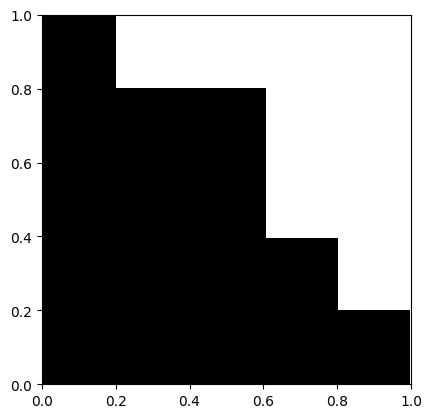

In [5]:
plot_sdf_mask_2d(omega_dose_example)

## Example Losses

In [6]:
def target_dose_example_first(y):
    return ((y[:, 0] - 0.3) ** 2 + (y[:, 1] - 0.9) ** 2)

def target_dose_example_second(y):
    return (torch.abs(y[:, 0] - 0.9) + (y[:, 1] - 0.3) ** 2)

def target_dose_example(z, y):
    """Target function.

    Args:
        z: Input features (patient attributes).
        y: Predicted treatment parameters.

    """
    return torch.where(
        z[:, 0] >= 0,
        target_dose_example_first(y),  # * z[:, 0],
        target_dose_example_second(y),  # * -z[:, 0],
    )

def target_dose_example_third(z, y):
    return (torch.abs(y[:, 0] - 0.9) + (y[:, 1] - 0.3 - z[:, 1] * 0.1) ** 2)

def target_dose_example_v2(z, y):
    """Target function.

    Args:
        z: Input features (patient attributes).
        y: Predicted treatment parameters.

    """
    return torch.where(
        z[:, 0] >= 0,
        target_dose_example_first(y),  # * z[:, 0],
        target_dose_example_third(z, y),  # * -z[:, 0],
    )


## Simple Neural Network with Output Constraints

Generate input feature vectors

In [7]:
gen = torch.Generator()
gen.manual_seed(12345)
# zs = torch.sign(torch.empty((200, 1)).uniform_(-1.0, 1.0, generator=gen))
# zs = torch.sign(torch.empty((500, 2)).uniform_(-1.0, 1.0, generator=gen))
zs = torch.empty((500, 3)).uniform_(-1.0, 1.0, generator=gen)
zs[:, 0] = torch.sign(zs[:, 0])
train_dataset = torch.utils.data.TensorDataset(zs)

### Extended Space Approach

The extended space:

$$
\tilde{\Omega} = \left\{
	 \zeta \in \mathbb{R}^{n + 1}
	 ~ | ~
	 \zeta_0 \in [-\nu, \nu], ~~ (\zeta_1, \dots, \zeta_n)^T \in \Omega
\right\}.
$$

$$
\tilde\Omega =
\{
	\zeta \in \mathbb{R}^{n + 1}
	~ | ~
	(\zeta_1, \dots, \zeta_n)^T \in \Omega
\}
\cap
\{
	\zeta \in \mathbb{R}^{n + 1}
	~ | ~
	\zeta_0 \in [0, 1]
\},
$$

therefore

$$
\rho_{\tilde{\Omega}}(\tilde{x}) = \max{
	\left\{
	\rho_{\Omega}(x), ~
	\tilde x_0 - \nu, ~
	-\nu - \tilde x_0
	\right\}
}.
$$

So **no specific implementation of the Ray Marching is needed**, we just modify the distance function.

The interesting case is when $\nu = \lvert \rho_\Omega(x) \rvert$, helping to avoid manual specification of $\nu$ and to obtain uniform-like distribution of points inside the domain (not along boundaries).

In [8]:
torch.manual_seed(123)

act = torch.nn.SiLU
nn = ESConstrainedNN(
    domain=omega_dose_example,
    pivot=torch.tensor([[0.2, 0.2]]),
    n_iter=5,
    encoder=torch.nn.Sequential(
        torch.nn.Linear(3, 8),
        act(),
        torch.nn.Linear(8, 8),
        act(),
    ),
    encoder_outs=8,
    decoder=lambda x: x,
    decoder_ins=2,
)

n_epochs = 1000
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
optim = torch.optim.AdamW(nn.parameters(), lr=1.e-4)
history = defaultdict(list)
trajectories = []

for _ in range(n_epochs):
    batch_losses = []
    for z, in train_loader:
        preds = nn(z)
        loss = target_dose_example(z, preds).sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        batch_losses.append(loss.item())
    with torch.inference_mode():
        trajectories.append(nn(zs).numpy())
    history['train_loss'].append(np.mean(batch_losses))

trajectories = np.stack(trajectories, axis=0)

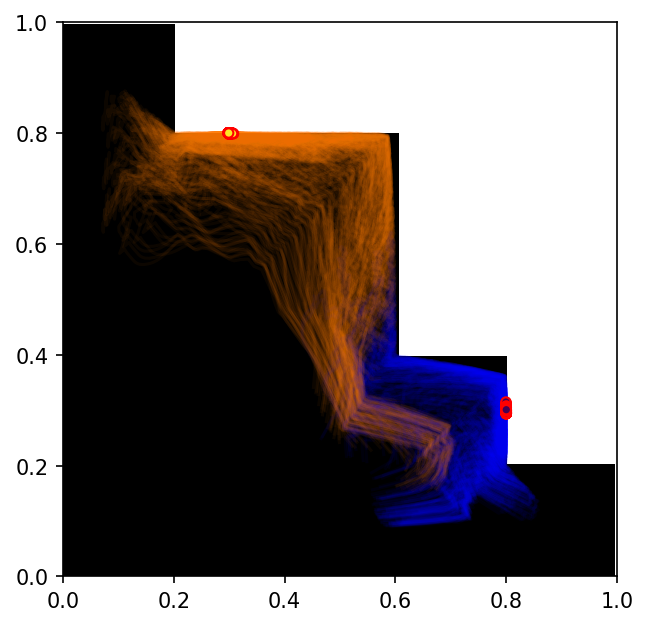

In [9]:
plt.figure(dpi=150)
plot_sdf_mask_2d(omega_dose_example)

for p in range(trajectories.shape[1]):
    plt.plot(*trajectories[:, p].T, c='tab:orange' if bool(zs[p, 0] >= 0.0) else 'b', alpha=0.05)

ys = nn(zs).detach().numpy()
plt.scatter(*ys.T, c=(zs[:, 0] >= 0.0), alpha=1.0, s=20, edgecolor='r', zorder=10)

### Ray & Scale Approach

Train simple constrained neural network

In [10]:
torch.manual_seed(123)

act = torch.nn.SiLU
nn2 = SimpleConstrainedNN(
    domain=omega_dose_example,
    pivot=torch.tensor([[0.2, 0.2]]),
    n_iter=10,
    encoder=torch.nn.Sequential(
        torch.nn.Linear(3, 8),
        act(),
        torch.nn.Linear(8, 8),
        act(),
    ),
    encoder_outs=8,
    decoder=lambda x: x,
    decoder_ins=2,
)

n_epochs = 1000
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
optim = torch.optim.AdamW(nn2.parameters(), lr=1.e-4)
history2 = defaultdict(list)
trajectories2 = []

for _ in range(n_epochs):
    batch_losses = []
    for z, in train_loader:
        preds = nn2(z)
        loss = target_dose_example(z, preds).sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        batch_losses.append(loss.item())
    with torch.inference_mode():
        trajectories2.append(nn2(zs).numpy())
    history2['train_loss'].append(np.mean(batch_losses))

trajectories2 = np.stack(trajectories2, axis=0)


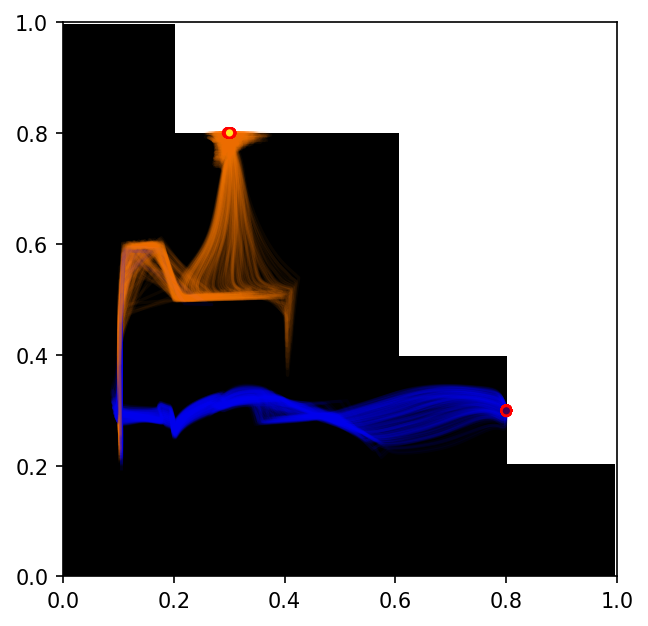

In [11]:
plt.figure(dpi=150)
plot_sdf_mask_2d(omega_dose_example)

for p in range(trajectories2.shape[1]):
    plt.plot(*trajectories2[:, p].T, c='tab:orange' if bool(zs[p, 0] >= 0.0) else 'b', alpha=0.05)

ys = nn2(zs).detach().numpy()
plt.scatter(*ys.T, c=(zs[:, 0] >= 0.0), alpha=1.0, s=20, edgecolor='r', zorder=10)

### Losses

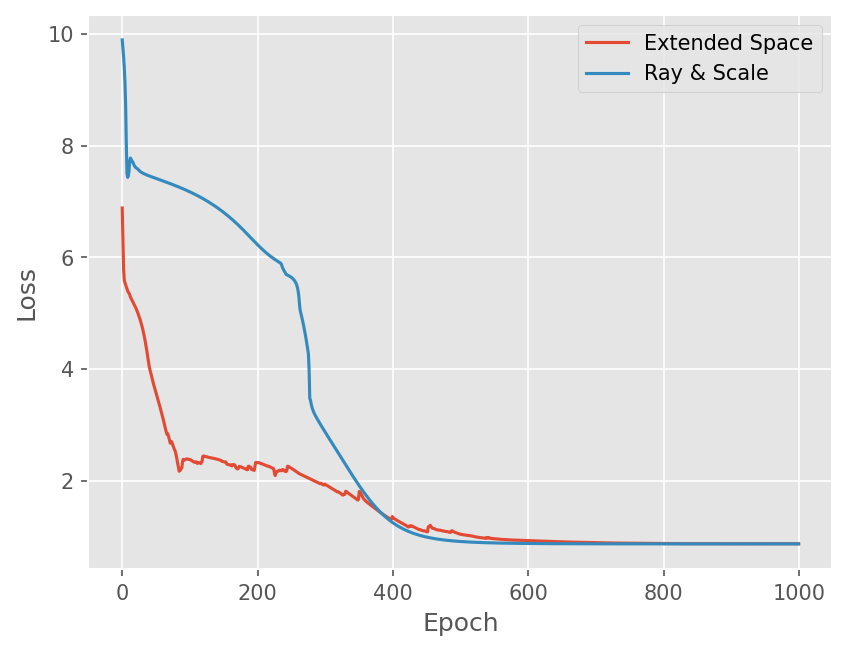

In [12]:
plt.figure(dpi=150)
with plt.style.context('ggplot'):
    for k, v in history.items():
        plt.plot(v, label='Extended Space')
    
    for k, v in history2.items():
        plt.plot(v, label='Ray & Scale')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')


## When Loss Function Depends Continuously on Inputs

In [13]:
gen = torch.Generator()
gen.manual_seed(12345)
zs = torch.empty((500, 3)).uniform_(-1.0, 1.0, generator=gen)
zs[:, 0] = torch.sign(zs[:, 0])
train_dataset = torch.utils.data.TensorDataset(zs)

In [14]:
torch.manual_seed(123)

nn3 = SimpleConstrainedNN(
    domain=omega_dose_example,
    pivot=torch.tensor([[0.2, 0.2]]),
    n_iter=10,
    encoder=torch.nn.Sequential(
        torch.nn.Linear(3, 8),
        act(),
        torch.nn.Linear(8, 8),
        act(),
    ),
    encoder_outs=8,
    decoder=lambda x: x,
    decoder_ins=2,
)

n_epochs = 1000
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
optim = torch.optim.AdamW(nn3.parameters(), lr=1.e-3)
history3 = defaultdict(list)
trajectories3 = []

for _ in range(n_epochs):
    batch_losses = []
    for z, in train_loader:
        preds = nn3(z)
        loss = target_dose_example_v2(z, preds).sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        batch_losses.append(loss.item())
    with torch.inference_mode():
        trajectories3.append(nn3(zs).numpy())
    history3['train_loss'].append(np.mean(batch_losses))

trajectories3 = np.stack(trajectories3, axis=0)


In [15]:
torch.manual_seed(123)

nn4 = ESConstrainedNN(
    domain=omega_dose_example,
    pivot=torch.tensor([[0.2, 0.2]]),
    n_iter=10,
    encoder=torch.nn.Sequential(
        torch.nn.Linear(3, 8),
        act(),
        torch.nn.Linear(8, 8),
        act(),
    ),
    encoder_outs=8,
    decoder=lambda x: x,
    decoder_ins=2,
)

n_epochs = 100
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optim = torch.optim.AdamW(nn4.parameters(), lr=1.e-3)
history4 = defaultdict(list)
trajectories4 = []

for _ in range(n_epochs):
    batch_losses = []
    for z, in train_loader:
        preds = nn4(z)
        loss = target_dose_example_v2(z, preds).sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        batch_losses.append(loss.item())
    with torch.inference_mode():
        trajectories4.append(nn4(zs).numpy())
    history4['train_loss'].append(np.mean(batch_losses))

trajectories4 = np.stack(trajectories4, axis=0)


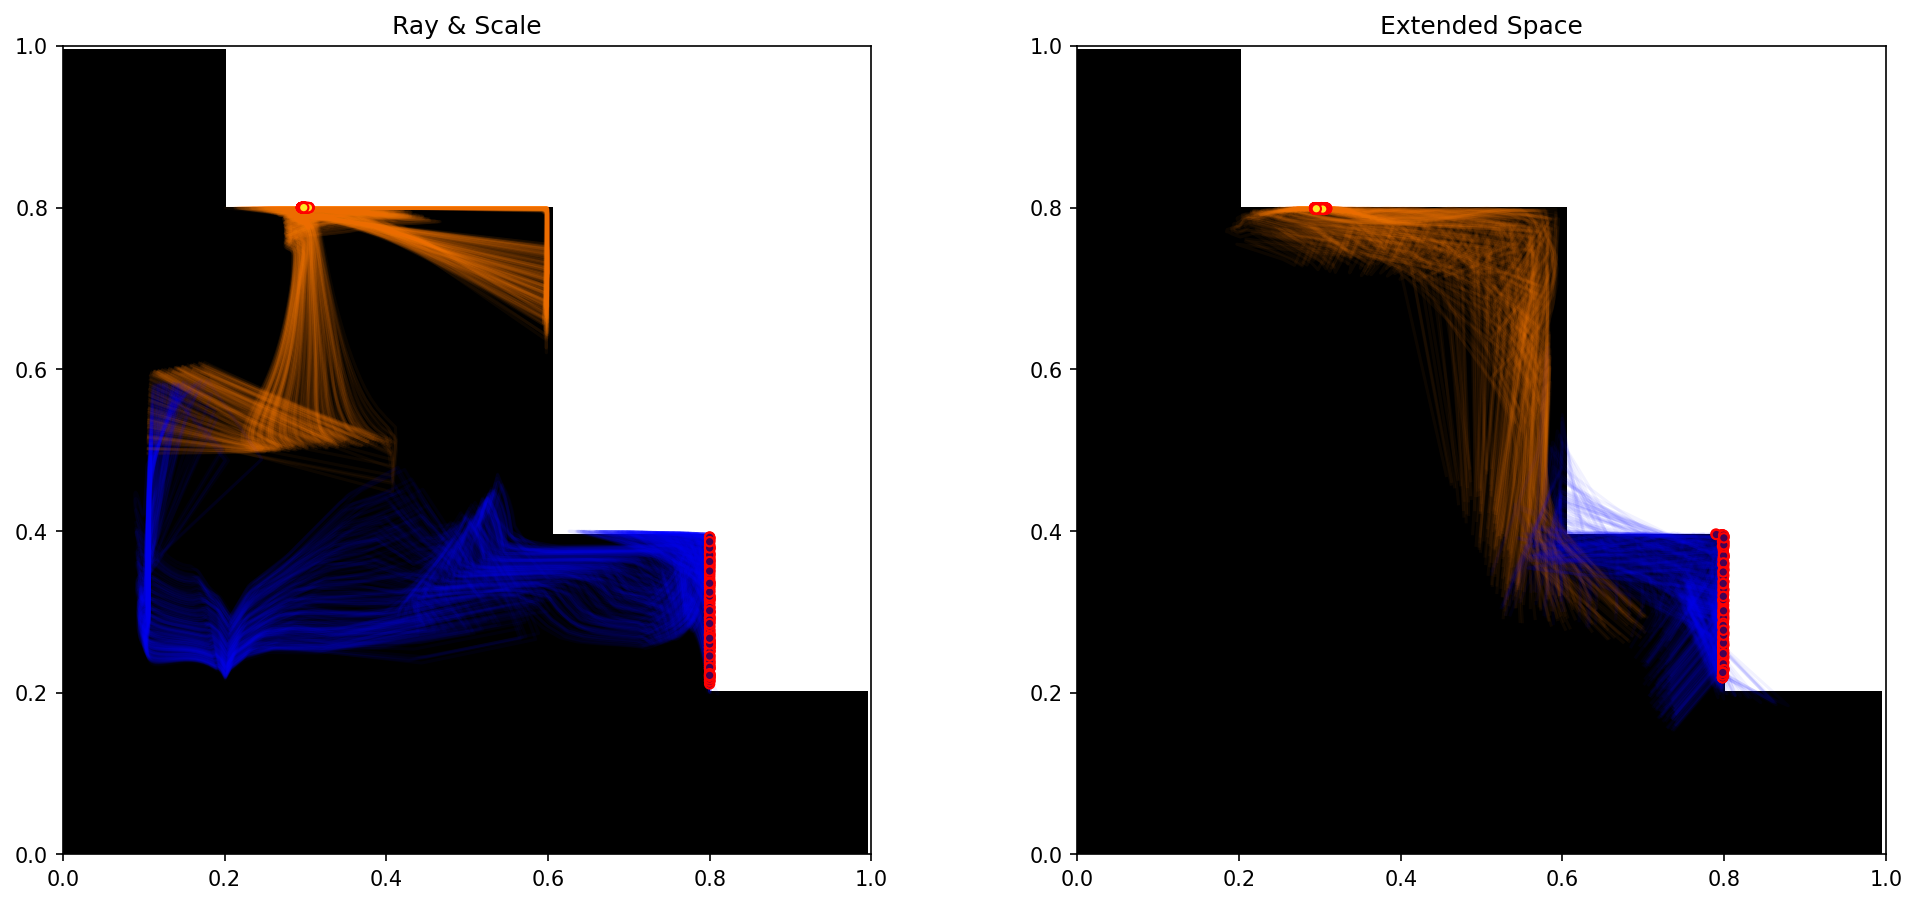

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), dpi=150)
for a, traj, cur_nn, name in zip(ax, [trajectories3, trajectories4], [nn3, nn4], ['Ray & Scale', 'Extended Space']):
    plot_sdf_mask_2d(omega_dose_example, a)
    
    for p in range(traj.shape[1]):
        a.plot(*traj[:, p].T, c='tab:orange' if bool(zs[p, 0] >= 0.0) else 'b', alpha=0.05)
    
    ys = cur_nn(zs).detach().numpy()
    a.scatter(*ys.T, c=(zs[:, 0] >= 0.0), alpha=1.0, s=20, edgecolor='r', zorder=10)
    a.set_title(name)
    

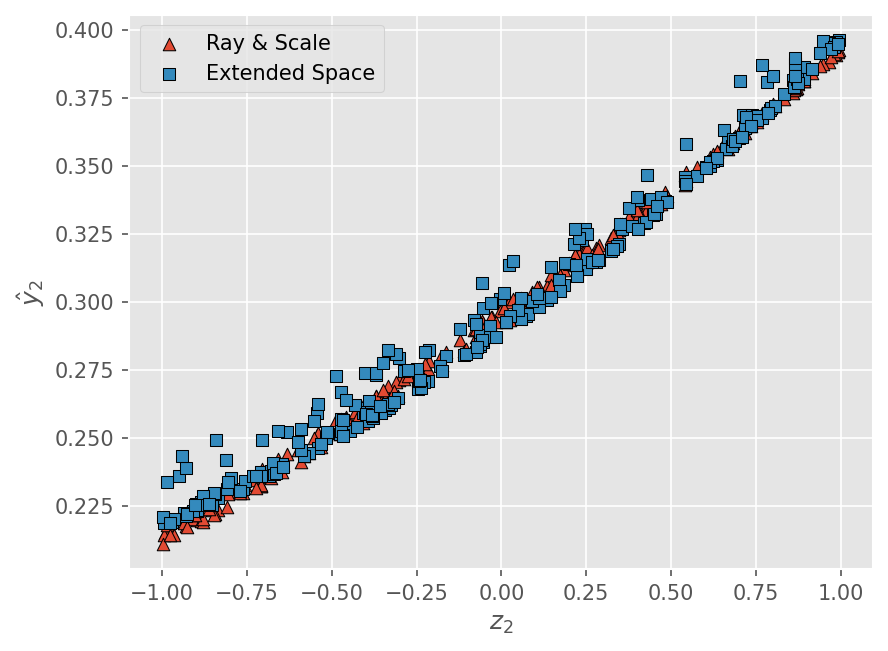

In [18]:
mask = ~(zs[:, 0] >= 0.0)
ys3 = nn3(zs).detach().numpy()
ys4 = nn4(zs).detach().numpy()

plt.figure(dpi=150)
with plt.style.context('ggplot'):
    plt.scatter(zs[mask][:, 1], ys3[mask][:, 1], marker='^', edgecolor='k', label='Ray & Scale')
    plt.scatter(zs[mask][:, 1], ys4[mask][:, 1], marker='s', edgecolor='k', label='Extended Space')
    plt.legend()

    plt.xlabel('$z_2$')
    plt.ylabel('$\hat{y}_2$')